In [1]:
#Import python libraries, please consult master python version list if errors from code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import dateutil.parser
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from rfpimp import *  # feature importance plot
from sklearn.metrics import *
import matplotlib.pyplot as plt
from matplotlib import *

In [2]:

def make_dataset(elec_path, meta_path, weather_path, weather_file, industry):
    '''
    INPUT
    elec_path: path to timeseries data of electricity meter (temp_open_utc_complete.csv)
    meta: path to meta data table (meta_open.csv)
    weather: path to weather data table (weatherX.csv)
    weather_file: name of the weather file
    industry: name of undustry to focus on
    OUTPUT
    A dataframe in which each record represents a building at a certain time
    columns =[
    building_name: name of the building from meta, str
    month: one-hot encoded
    day: from elec, int
    day_of_the_week: one-hot encoded
    hour: from elec, hour from weather is converted to the nearest :00, int
    area: from meta, float
    primary_space_usage: from meta (primaryspaceuse_abbrev), one-hot encoded
    electricity: from elec
    temperature: from weather
    ]
    ------------------------------------------------------------------------------------------------------------------------------------------
    comment:
    -humidity is sometimes missing in weather table
    '''

    # Function to get rid of minute in timestamp, aligning time by hour only    
    def cutoff_minute(dt):
        '''
        INPUT
        a datetime object has year, month, day, hour, and minute
        OUTPUT
        a datetime object has year, month, day, and hour
        '''
        year = dt.year
        month = dt.month
        day = dt.day
        hour = dt.hour
        return datetime.datetime(year, month, day, hour)

    def sniff(df):
        with pd.option_context("display.max_colwidth", 20):
            info = pd.DataFrame()
            info['sample'] = df.iloc[0]
            info['data type'] = df.dtypes
            info['percent missing'] = df.isnull().sum()*100/len(df)
            return info.sort_values('data type')

    #read tables
    elec = pd.read_csv(elec_path)
    meta = pd.read_csv(meta_path)
    weather = pd.read_csv(weather_path)

    #set 'uid' as index in meta
    meta = meta.set_index('uid')

    #parse date
    weather['timestamp'] = weather['timestamp'].apply(dateutil.parser.parse) #changing timestamp from string to date time
    elec['timestamp'] = elec['timestamp'].apply(dateutil.parser.parse) # ""

    #construct the dataframe to return
    # Use the inputted Industry to pull all buildings from that industry
    buildings = list(meta[(meta['newweatherfilename'] == weather_file) & (meta['industry']==industry)].index) 

    #Creat an empty dataframe with 5 columns
    global df
    df = pd.DataFrame(columns=['building_name', 'timestamp', 'electricity', 'area', 'primary_space_usage']) 

    #for now, this loop is fine, but maybe rewrite to make code faster/ look for function in pandas
    for building in buildings:
    #filename followed by [['column name']] selects specific columns in datafram
        subdf = elec[['timestamp', building]] #extracting the timestamp and electricity data from all buildings in electricity table
        subdf.columns = ['timestamp', 'electricity'] #naming columns
        subdf['building_name'] = building #non temporal column with building name, all same entry
        subdf['area'] = meta.loc[building, 'sqm'] #"" making new column called area
        subdf['primary_space_usage'] = meta.loc[building, 'primaryspaceuse_abbrev']
        df = pd.concat([df, subdf], axis=0, ignore_index=True) #combining the two tables. Where axis =0 puts the table under the first one, axis = 1 puts the table to the right 
        #df has 'building_name', timestamp, electricity meter, area, primary space usage
        # The timestamps are not matched up in the minutes between external and building data, cutoff the minutes and just match to hour 
        weather['rounded_timestamp'] = weather['timestamp'].apply(cutoff_minute) 
        #cutoff_minute is a function that is implemented below
    weather = weather.groupby('rounded_timestamp').first() #only the first observation in each hour is taken
    weather = weather['TemperatureC'] #only need temperature column

    df['timestamp'] = df['timestamp'].apply(cutoff_minute) #to drop timezone information
    df = df.join(weather, on='timestamp', how='inner', lsuffix='elec', rsuffix='weather') #join temperature data from weather table 
    #join aligns the tables by the timestamp index, instead of merely merging them, so that each instinance of a timestamp for each building has weather data

    #Adding columns for the month, year, date, hour, and weekday
    df['month']=df['timestamp'].apply(lambda x: x.month)
    df['year']=df['timestamp'].apply(lambda x: x.year)
    df['date']=df['timestamp'].apply(lambda x: x.day)
    df['hour']=df['timestamp'].apply(lambda x: x.hour)
    df['weekday']=df['timestamp'].apply(lambda x: x.dayofweek)

    #One-hot encode for month, year, date, hour, and weekday is pd.get_dummies
    #combining df with one-hot encodes the tables.  axis =1 puts the table under the first one, axis = 0 puts the table to the right 
    df.reset_index()
    df = pd.concat([df, pd.get_dummies(df['month'], prefix='month')],axis=1) 
    df = pd.concat([df, pd.get_dummies(df['date'], prefix='date')], axis=1) 
    df = pd.concat([df, pd.get_dummies(df['hour'], prefix='hour')], axis=1) 
    df = pd.concat([df, pd.get_dummies(df['weekday'], prefix='wkday')], axis=1) 
    df = pd.concat([df, pd.get_dummies(df['primary_space_usage'], prefix='PSU')], axis=1) 
    
    df.reset_index()

    return df




In [3]:
#Post Processing Input Data
#display(sniff(df))
#df['building_name'].value_counts(dropna=False)

In [4]:
#Code chunk that splits the time dependent data and makes the 
# Feature matrix and target vector

def data_split(f_valid, f_test, df):
    # Split the time series data into train, test, and validate

    global f_train
    f_train=1-f_valid-f_test
    # sort by timestamp and then drop all the columns with NaN 

    df = df.sort_values('timestamp')
    df = df.replace(np.nan, 0) #Don't want any NaNs

    # indices and break up of dataset
    n_valid = int(len(df)*f_valid)
    n_test = int(len(df)*f_test)
    n_train = len(df)-n_valid-n_test

    df_train = df[:n_train].reset_index(drop=True)
    df_valid = df[n_train:n_train+n_valid].reset_index(drop=True)
    df_test = df[-n_test:].reset_index(drop=True)
    
    #Checking the number of building entries in each data set
    #display(df_train['building_name'].value_counts(dropna=False))
    #display(df_valid['building_name'].value_counts(dropna=False))
    #display(df_test['building_name'].value_counts(dropna=False))
    
    #Define the independent variable to plot against
    global ind_var
    ind_var=df_valid['timestamp']

    # drop the columns that are not onehot/redundant
    df_train = df_train.drop('primary_space_usage', axis=1)#redundant and RF doesnt like this
    df_train = df_train.drop('building_name', axis=1) #Have not one hot encoded over this 
    df_train = df_train.drop('timestamp', axis=1) #redundant and RF doesnt like this
    
    df_test = df_test.drop('primary_space_usage', axis=1)#redundant and RF doesnt like this
    df_test = df_test.drop('building_name', axis=1) #Have not one hot encoded over this 
    df_test = df_test.drop('timestamp', axis=1) #redundant and RF doesnt like this

    df_valid = df_valid.drop('primary_space_usage', axis=1)#redundant and RF doesnt like this
    df_valid = df_valid.drop('building_name', axis=1) #Have not one hot encoded over this 
    df_valid = df_valid.drop('timestamp', axis=1) #redundant and RF doesnt like this

    #Test that data sets are in order of time and correct size
    #display(df_train['timestamp'].head(1))
    #display(df_train['timestamp'].tail(1))
    #display(df_valid['timestamp'].head(1))
    #display(df_valid['timestamp'].tail(1))
    #display(df_test['timestamp'].head(1))
    #display(df_test['timestamp'].tail(1))

    # Making the feature matrix and the target vector
    global X,y,X_valid, y_valid,Xt, yt
    X, y = df_train.drop('electricity', axis=1), df_train['electricity']
    X_valid, y_valid = df_valid.drop('electricity', axis=1), df_valid['electricity']
    Xt, yt = df_test.drop('electricity', axis=1), df_test['electricity']

    #display(df_train.columns)
    #print('The shape of the feature space/target is:', X.shape,y.shape)

    return f_train,ind_var, X.reset_index(),y.reset_index(),X_valid.reset_index(),y_valid.reset_index(),Xt.reset_index(),yt.reset_index()
    

In [33]:
# Train the model, measure accuracy, and error metrics

def make_model(X, y, X_valid, y_valid, n_estimators,
              max_features, min_samples_leaf):

    #Making the model
    global rf
    
    rf = RandomForestRegressor(n_estimators=n_estimators,
                           n_jobs=-1,
                           oob_score=True,
                           max_features=max_features, 
                           min_samples_leaf=min_samples_leaf)

    #Inputting train dataset into the model
    rf.fit(X, y)

    return rf


In [65]:
# Using the model to make a prediction & Error Analysis for Random Forest 

def run_model(X_valid):
    global n, h, oob_valid
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    global y_pred
    y_pred = rf.predict(X_valid)
    global mae_valid, rmsle_valid, r2_score_valid
    mae_valid = mean_absolute_error(np.exp(y_valid), np.exp(y_pred))
    rmsle_valid = np.sqrt( mean_squared_error(y_valid, y_pred) )
    r2_score_valid = rf.score(X_valid, y_valid)

    display(rmsle_valid)
    display(mae_valid)
    
    oob_valid = rf.oob_score_

    print(f"RF OOB score {rf.oob_score_:.5f} using {n:,d} tree nodes {h} median tree height")
    print(f"Validation R^2 {r2_score_valid:.5f}, RMSLE {rmsle_valid:.5f}, MAE {mae_valid:.2E}")
    
    return y_pred,rmsle_valid,mae_valid,r2_score_valid, n, h, oob_valid

In [86]:

def plot_timestamp(y_valid,y_pred,ind_var,f_train,n_estimators,max_features,min_samples_leaf,industry,rmsle_valid,mae_valid,r2_score_valid,oob_valid):
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    plt.plot(ind_var,y_pred,'bs')
    plt.plot(ind_var,y_valid,'g^')
    plt.title('Bldg={},% yr train={}, max_features={}, min leaves={}, {} trees, {} tree nodes/ {} median height'.format(industry,f_train,n_estimators,max_features,min_samples_leaf,n,h))
    
    plt.ylabel('Electricity Use in kWhr')
    plt.xlabel('Timestamp') 
    plt.legend(['Predicted','Observed'])
    plt.figure(figsize=(20,20))
    plt.show()
    
    ax1 = plt.subplot(212)
    ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
    ax1.plot(ind_var,y_pred,'bs')
    ax1.plot(ind_var,y_valid,'g^')
    plt.ylabel('Electricity Use in kWhr')
    plt.xlabel('Timestamp')

    ax2 = plt.subplot(221)
    ax2.margins(0.5, 0.5)           # Values >0.0 zoom out
    ax2.plot(ind_var,y_pred,'bs')
    ax2.plot(ind_var,y_valid,'g^')
    plt.ylabel('Electricity Use in kWhr')
    ax2.set_title('RMSLE {:.2f}// MAE {:.2E}// R^2 {:.2f}// OOBScore {:.2f}'.format(rmsle_valid,mae_valid,r2_score_valid,oob_valid))
    plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

    ax3 = plt.subplot(222)
    ax3.margins(x=-0.45, y=-0.45)   # Values in (-0.5, 0.0) zooms in to center
    ax3.plot(ind_var,y_pred,'bs')
    ax3.plot(ind_var,y_valid,'g^')
    ax3.set_title('Zoomed in')
    plt.ylim([100,300])
    plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

    from pylab import rcParams
    rcParams['figure.figsize'] = 14, 4


    plt.show()

    return


Dataset made, now splitting data...
Data has been spllit, now making model..
Random Forest model created, now running model...


17.024208509668302

1.5375479515034172e+98

RF OOB score 0.98545 using 66,932,962 tree nodes 52.0 median tree height
Validation R^2 0.48013, RMSLE 17.02421, MAE 1.54E+98
Model ran, now plotting results...


/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


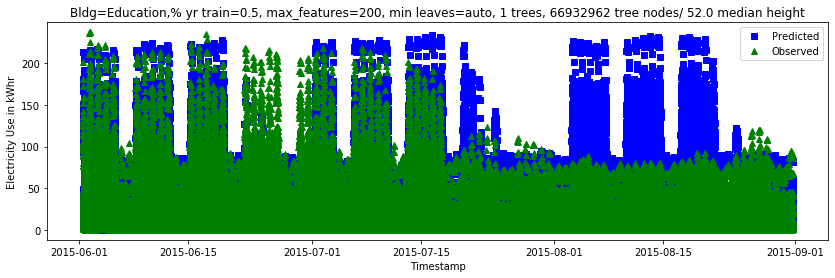

<Figure size 1440x1440 with 0 Axes>

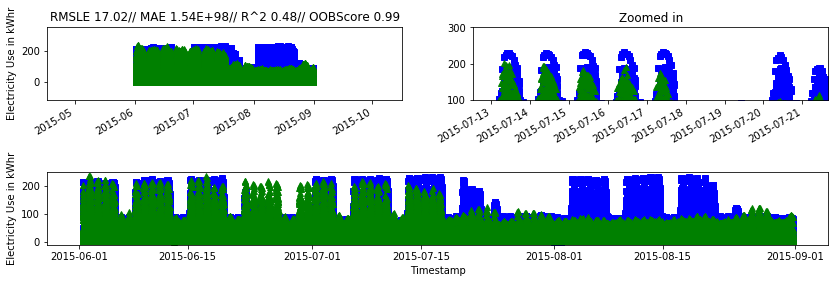

In [87]:
# Run Code

#-----------------------------------------INPUTS--------------------------------------------------#
#Make Dataset Input block
elec_path = '/Users/christiannalininger/Desktop/bldggenome/data/processed/temp_open_utc_complete.csv'
meta_path = '/Users/christiannalininger/Documents/GitHub/gdso_2019/data/raw/meta_open.csv'
weather_path = '/Users/christiannalininger/Documents/GitHub/gdso_2019/data/external/weather/weather1.csv'
industry = "Education"
weather_file = "weather1.csv"
#Data Split Input block
f_valid = 0.25 # fraction of data for validate = fraction for test also
f_test = 0.25 # fraction of data test
#Random Forest Model Inputs
n_estimators=200 #Number of trees: tradeoff between accuracy and cost here
max_features='auto' #maximum number of features to train on
min_samples_leaf=1 #minimum number of data points to make a new leaf on a tree

# MAX_FEATURES:
#If int, then consider max_features features at each split.
#If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
#If “auto”, then max_features=sqrt(n_features).
#If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
#If “log2”, then max_features=log2(n_features).
#If None, then max_features=n_features.

#-----------------------------------------RUN CODE--------------------------------------------------#

#make_dataset(elec_path, meta_path, weather_path, weather_file, industry)
print('Dataset made, now splitting data...')
data_split(f_valid, f_test, df)
print('Data has been spllit, now making model..')
make_model(X, y, X_valid, y_valid, n_estimators,max_features, min_samples_leaf)
print('Random Forest model created, now running model...')
run_model(X_valid)
print('Model ran, now plotting results...')
plot_timestamp(y_valid,y_pred,ind_var,f_train,n_estimators,max_features,min_samples_leaf,industry,rmsle_valid,mae_valid,r2_score_valid,oob_valid)
